# Pedro y el Lobo: Entorno Realista

En nuestra situación, Pedro podía moverse casi sin cansarse ni sentir hambre. En un mundo más realista, tendría que sentarse y descansar de vez en cuando, además de alimentarse. Hagamos nuestro mundo más realista implementando las siguientes reglas:

1. Al moverse de un lugar a otro, Pedro pierde **energía** y gana algo de **fatiga**.
2. Pedro puede recuperar energía comiendo manzanas.
3. Pedro puede deshacerse de la fatiga descansando bajo un árbol o en la hierba (es decir, entrando en una ubicación del tablero con un árbol o hierba - campo verde).
4. Pedro necesita encontrar y matar al lobo.
5. Para matar al lobo, Pedro necesita tener ciertos niveles de energía y fatiga; de lo contrario, perderá la batalla.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

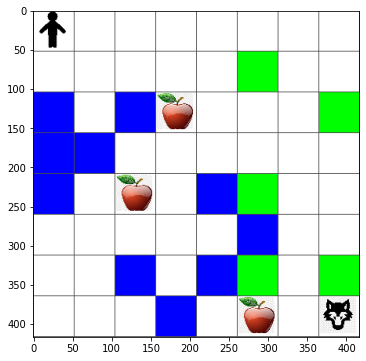

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definiendo el estado

En nuestras nuevas reglas del juego, necesitamos hacer un seguimiento de la energía y la fatiga en cada estado del tablero. Por lo tanto, crearemos un objeto `state` que llevará toda la información necesaria sobre el estado actual del problema, incluyendo el estado del tablero, los niveles actuales de energía y fatiga, y si podemos vencer al lobo mientras estamos en el estado terminal:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Función de Recompensa

La función de recompensa es una parte crucial del sistema, ya que define cómo se evalúa el comportamiento del agente. A continuación, se detallan algunos aspectos importantes:

### Objetivo
El objetivo principal de la función de recompensa es guiar al agente hacia el logro de la tarea deseada. Esto se logra asignando valores positivos o negativos según las acciones que el agente realice.

### Consideraciones clave
- **Diseño cuidadoso**: Una función de recompensa mal diseñada puede llevar al agente a comportamientos no deseados.
- **Equilibrio**: Es importante equilibrar las recompensas para evitar que el agente se enfoque únicamente en maximizar una métrica específica, ignorando otras consideraciones importantes.
- **Escalabilidad**: Asegúrate de que la función de recompensa sea escalable y pueda adaptarse a diferentes escenarios.

### Ejemplo
Aquí hay un ejemplo básico de una función de recompensa:

```python
def reward_function(state, action):
    if action == "desired_action":
        return 10  # Recompensa positiva
    else:
        return -1  # Penalización
```

En este ejemplo:
- Se otorga una recompensa positiva de 10 cuando el agente realiza la acción deseada.
- Se aplica una penalización de -1 para cualquier otra acción.

### Buenas prácticas
- **Pruebas exhaustivas**: Prueba la función de recompensa en múltiples escenarios para asegurarte de que produce los resultados esperados.
- **Iteración**: Ajusta la función de recompensa según sea necesario para mejorar el rendimiento del agente.
- **Evitar recompensas excesivas**: Las recompensas excesivas pueden llevar a un comportamiento no natural o a la explotación de la función de recompensa.

### Conclusión
Una función de recompensa bien diseñada es esencial para el éxito del agente. Dedica tiempo a planificar, probar y ajustar la función para garantizar que el agente se comporte de manera óptima.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritmo de Q-Learning

El algoritmo de aprendizaje en sí permanece prácticamente sin cambios, simplemente usamos `state` en lugar de solo la posición del tablero.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

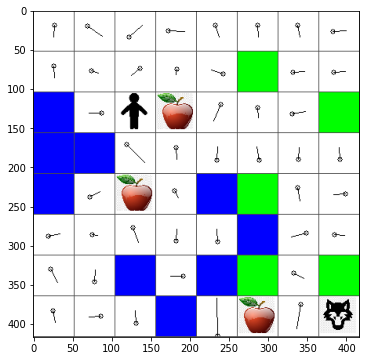

In [11]:
m.plot(Q)

## Resultados

¡Veamos si tuvimos éxito entrenando a Peter para luchar contra el lobo!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Ahora vemos muchos menos casos de ahogamiento, pero Peter todavía no siempre puede matar al lobo. Intenta experimentar y ver si puedes mejorar este resultado jugando con los hiperparámetros.


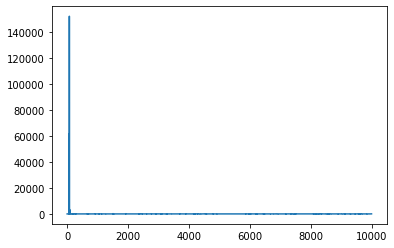

In [13]:
plt.plot(lpath)


---

**Descargo de responsabilidad**:  
Este documento ha sido traducido utilizando el servicio de traducción automática [Co-op Translator](https://github.com/Azure/co-op-translator). Aunque nos esforzamos por garantizar la precisión, tenga en cuenta que las traducciones automatizadas pueden contener errores o imprecisiones. El documento original en su idioma nativo debe considerarse como la fuente autorizada. Para información crítica, se recomienda una traducción profesional realizada por humanos. No nos hacemos responsables de malentendidos o interpretaciones erróneas que puedan surgir del uso de esta traducción.
